# Generating trading signals with Linear Regression

This notebook illustrates the following steps:
1. **Cross-validation in the time-series context** poses the additional challenge that train and validation sets need to respect the temporal order of the data so that we do not inadvertently train the model on data 'from the future' to predict the past and introduce lookahead bias. Scikit-learn's built-in [TimeSeriesSplit](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html) aims to accomplish this but does not work for this case where we have multiple time series, one for each ticker. We could solve this by manually subsetting the data for the appropriate train and validation periods. Alternatively, we can create a custom time-series splitter compatible with the scikit-learn Kfold interface (see resources). Here is an [example](https://github.com/stefan-jansen/machine-learning-for-trading/blob/master/utils.py) that illustrates how to do so for this case. This allows us to specify fixed `train_length` and `test_length` parameters, as well as a `lookahead` value that defines the forecast horizon and ensures an appropriate gap between the training and validation set.
2. To establish a **baseline**, train a [LinearRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) using five years of training data to predict rolling windows of three months of returns for the years 2013-2016. Evaluate the results by computing the information coefficient (IC) as the Spearman rank correlation between the predictions and the actual returns, averaged per day.
3. Next, we'll use **regularized regression** models that include a penalty term to shrink the coefficients and limit the risk of overfitting. Cross-validate a range of `alpha` penalty values for [Lasso](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html) and [Ridge](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html#sklearn.linear_model.Ridge) using the same training and validation periods as for the linear regression baseline and compare their performance.

## Imports

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline

from pathlib import Path
import sys, os
from time import time
from collections import defaultdict
from itertools import product

import numpy as np
import pandas as pd
import statsmodels.api as sm

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import MinMaxScaler

from scipy.stats import spearmanr

import matplotlib.pyplot as plt
import seaborn as sns

In [44]:
from matplotlib.ticker import FuncFormatter
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler


## Settings

In [3]:
sns.set_style('whitegrid')

In [4]:
np.random.seed(42)

## Get Data

In [5]:
DATA_PATH = Path('.', 'data')

In [6]:
data = (pd.read_hdf(DATA_PATH / 'stock_prices.h5', 'model_data')
        .sort_index())

In [7]:
data.info

<bound method DataFrame.info of                      ret_01    ret_03    ret_05    ret_10    ret_21    ret_42  \
ticker date                                                                     
A      2006-01-03       NaN       NaN       NaN       NaN       NaN       NaN   
       2006-01-04  0.002687       NaN       NaN       NaN       NaN       NaN   
       2006-01-05  0.026198       NaN       NaN       NaN       NaN       NaN   
       2006-01-06  0.005222  0.034328       NaN       NaN       NaN       NaN   
       2006-01-09 -0.002886  0.028580       NaN       NaN       NaN       NaN   
...                     ...       ...       ...       ...       ...       ...   
ZMH    2015-06-26  0.002560  0.007810  0.007989  0.012121  0.001499 -0.025243   
       2015-06-29  0.000000  0.000352  0.001411  0.016925 -0.004645 -0.013496   
       2015-06-30  0.000000  0.002560  0.007810  0.008974 -0.010543  0.035901   
       2015-07-01  0.000000  0.000000  0.000352  0.009422 -0.005256  0.030367

In [19]:
idx = pd.IndexSlice
tdata = data.loc[idx[:, '2013':'2016'], :]
#tdata
targets = tdata['ret_fwd']
tdata.drop('ret_fwd', axis=1)

ret_01    ret_03    ret_05    ret_10    ret_21    ret_42  \
ticker date                                                                     
A      2013-01-01  0.000000  0.007382 -0.000712 -0.008438  0.082298  0.109209   
       2013-01-02  0.022960  0.051469  0.026732  0.034320  0.101050  0.116274   
       2013-01-03  0.003582  0.026624  0.034203  0.018700  0.089845  0.100664   
       2013-01-04  0.019748  0.046898  0.076073  0.046662  0.121228  0.143307   
       2013-01-07 -0.007233  0.015998  0.039326  0.038585  0.128133  0.156581   
...                     ...       ...       ...       ...       ...       ...   
ZMH    2015-06-26  0.002560  0.007810  0.007989  0.012121  0.001499 -0.025243   
       2015-06-29  0.000000  0.000352  0.001411  0.016925 -0.004645 -0.013496   
       2015-06-30  0.000000  0.002560  0.007810  0.008974 -0.010543  0.035901   
       2015-07-01  0.000000  0.000000  0.000352  0.009422 -0.005256  0.030367   
       2015-07-02  0.000000  0.000000  0.002560  0.002295 -0.002985  0.028039   

                     ret_63   ret_126   ret_252     BB_UP  ...    RMW_63  \
ticker date                                                ...             
A      2013-01-01  0.046958  0.093766  0.058500  0.031500  ...       NaN   
       2013-01-02  0.080367  0.122759  0.082804  0.012547  ...  0.001895   
       2013-01-03  0.089845  0.135870  0.061410  0.011377  ...  0.002263   
       2013-01-04  0.126224  0.179551  0.048801 -0.005911  ...  0.001288   
       2013-01-07  0.140195  0.154580  0.026785  0.002802  ...  0.002491   
...                     ...       ...       ...       ...  ...       ...   
ZMH    2015-06-26 -0.031631 -0.001015  0.102026  0.009507  ... -0.000724   
       2015-06-29 -0.040370 -0.001540  0.091204  0.007404  ...  0.000008   
       2015-06-30 -0.031796  0.004354  0.091516  0.006505  ...  0.001014   
       2015-07-01 -0.020713 -0.005026  0.088713  0.006034  ...  0.000916   
       2015-07-02 -0.026827  0.005062  0.088713  0.006406  ...  0.000869   

                     CMA_63  ALPHA_252  MARKET_252   SMB_252   HML_252  \
ticker date                                                              
A      2013-01-01       NaN        NaN         NaN       NaN       NaN   
       2013-01-02 -0.014374   0.000121    0.014272 -0.000147 -0.000763   
       2013-01-03 -0.013711   0.000142    0.014301 -0.000063 -0.000733   
       2013-01-04 -0.013072   0.000108    0.014309  0.000240 -0.001229   
       2013-01-07 -0.012991   0.000120    0.014351  0.000169 -0.001078   
...                     ...        ...         ...       ...       ...   
ZMH    2015-06-26 -0.004724  -0.000135    0.010424 -0.000492 -0.007634   
       2015-06-29 -0.005758   0.000003    0.010102 -0.000475 -0.007501   
       2015-06-30 -0.003544   0.000003    0.010105 -0.000454 -0.007459   
       2015-07-01 -0.003234  -0.000024    0.010065 -0.000381 -0.007419   
       2015-07-02 -0.004261  -0.000010    0.010068 -0.000409 -0.007488   

                    RMW_252   CMA_252  month  weekday  
ticker date                                            
A      2013-01-01       NaN       NaN      0        1  
       2013-01-02 -0.002645 -0.010980      0        2  
       2013-01-03 -0.002452 -0.010788      0        3  
       2013-01-04 -0.002138 -0.009865      0        4  
       2013-01-07 -0.001887 -0.009919      0        0  
...                     ...       ...    ...      ...  
ZMH    2015-06-26 -0.001167  0.007373      5        4  
       2015-06-29 -0.000898  0.006953      5        0  
       2015-06-30 -0.000888  0.007072      5        1  
       2015-07-01 -0.000933  0.007014      6        2  
       2015-07-02 -0.000962  0.007147      6        3  

[499713 rows x 47 columns]

## Custom Time Series Cross-Validation

In [9]:
class MultipleTimeSeriesCV:
    """Generates tuples of train_idx, test_idx pairs
    Assumes the MultiIndex contains levels 'symbol' and 'date'
    purges overlapping outcomes"""

    def __init__(self,
                 n_splits=3,
                 train_period_length=126,
                 test_period_length=21,
                 lookahead=None,
                 date_idx='date',
                 shuffle=False):
        self.n_splits = n_splits
        self.lookahead = lookahead
        self.test_length = test_period_length
        self.train_length = train_period_length
        self.shuffle = shuffle
        self.date_idx = date_idx

    def split(self, X, y=None, groups=None):
        """Generate the positional indices for the train-test splits for each fold"""
        unique_dates = X.index.get_level_values(self.date_idx).unique() # get unique dates
        days = sorted(unique_dates, reverse=True)
        split_idx = []
        for i in range(self.n_splits):
            # create train/test start and end indices
            test_end_idx = i * self.test_length
            test_start_idx = test_end_idx + self.test_length
            train_end_idx = test_start_idx + self.lookahead - 1
            train_start_idx = train_end_idx + self.train_length + self.lookahead - 1
            split_idx.append([train_start_idx, train_end_idx,
                              test_start_idx, test_end_idx])

        dates = X.reset_index()[[self.date_idx]]
        for train_start, train_end, test_start, test_end in split_idx:

            train_idx = dates[(dates[self.date_idx] > days[train_start])
                              & (dates.date <= days[train_end])].index
            test_idx = dates[(dates.date > days[test_start])
                             & (dates.date <= days[test_end])].index
            if self.shuffle:
                np.random.shuffle(list(train_idx))
            yield train_idx.to_numpy(), test_idx.to_numpy()

    def get_n_splits(self, X, y, groups=None):
        return self.n_splits


## Model Selection: Lookback, lookahead and roll-forward periods

In [20]:
YEAR = 252
train_period_length = 63
test_period_length = 10
n_splits = int(3 * YEAR/test_period_length)
lookahead =1 

cv = MultipleTimeSeriesCV(n_splits=n_splits,
                          test_period_length=test_period_length,
                          lookahead=lookahead,
                          train_period_length=train_period_length)

In [21]:
X = tdata.dropna()

In [22]:
targets.head

<bound method NDFrame.head of ticker  date      
A       2013-01-01    0.022960
        2013-01-02    0.003582
        2013-01-03    0.019748
        2013-01-04   -0.007233
        2013-01-07   -0.007991
                        ...   
ZMH     2015-06-26    0.000000
        2015-06-29    0.000000
        2015-06-30    0.000000
        2015-07-01    0.000000
        2015-07-02    0.000000
Name: ret_fwd, Length: 499713, dtype: float64>

## Baseline: Linear Regression

In [23]:
lr_predictions, lr_scores = [], []
lr = LinearRegression()
for i, (train_idx, test_idx) in enumerate(cv.split(X), 1):
    X_train, y_train, = X.iloc[train_idx], targets.iloc[train_idx]
    X_test, y_test = X.iloc[test_idx], targets.iloc[test_idx]
    lr.fit(X=X_train, y=y_train)
    y_pred = lr.predict(X_test)

    preds = y_test.to_frame('actuals').assign(predicted=y_pred)
    preds_by_day = preds.groupby(level='date')
    scores = pd.concat([preds_by_day.apply(lambda x: spearmanr(x.predicted,
                                                               x.actuals)[0] * 100)
                        .to_frame('ic')], axis=1)

    lr_scores.append(scores)
    lr_predictions.append(preds)

lr_scores = pd.concat(lr_scores)
lr_predictions = pd.concat(lr_predictions)

In [24]:
lr_r, lr_p = spearmanr(lr_predictions.actuals, lr_predictions.predicted)
print(f'Information Coefficient (overall): {lr_r:.3%} (p-value: {lr_p:.4%})')

Information Coefficient (overall): -0.241% (p-value: 14.5803%)


In [25]:
def plot_preds_scatter(df, ticker=None):
    if ticker is not None:
        idx = pd.IndexSlice
        df = df.loc[idx[ticker, :], :]
    j = sns.jointplot(x='predicted', y='actuals',
                      robust=True, ci=None,
                      line_kws={'lw': 1, 'color': 'k'},
                      scatter_kws={'s': 1},
                      data=df,
                      kind='reg')
    j.ax_joint.yaxis.set_major_formatter(
        FuncFormatter(lambda y, _: '{:.1%}'.format(y)))
    j.ax_joint.xaxis.set_major_formatter(
        FuncFormatter(lambda x, _: '{:.1%}'.format(x)))
    j.ax_joint.set_xlabel('Predicted')
    j.ax_joint.set_ylabel('Actuals')

In [27]:
def plot_ic_distribution(df, ax=None):
    if ax is not None:
        sns.distplot(df.ic, ax=ax)
    else:
        ax = sns.distplot(df.ic)
    mean, median = df.ic.mean(), df.ic.median()
    ax.axvline(0, lw=1, ls='--', c='k')
    ax.text(x=.05, y=.9,
            s=f'Mean: {mean:8.2f}\nMedian: {median:5.2f}',
            horizontalalignment='left',
            verticalalignment='center',
            transform=ax.transAxes)
    ax.set_xlabel('Information Coefficient')
    sns.despine()
    plt.tight_layout()

In [36]:
def plot_rolling_ic(df):
    fig, axes = plt.subplots(nrows=1, sharex=True, figsize=(14, 8))
    rolling_result = df.sort_index().rolling(21).mean().dropna()
    mean_ic = df.ic.mean()
    rolling_result.ic.plot(
                           title=f'Information Coefficient (Mean: {mean_ic:.2f})',
                           lw=1)
    axes.axhline(0, lw=.5, ls='-', color='k')
    axes.axhline(mean_ic, lw=1, ls='--', color='k')

    sns.despine()
    plt.tight_layout()

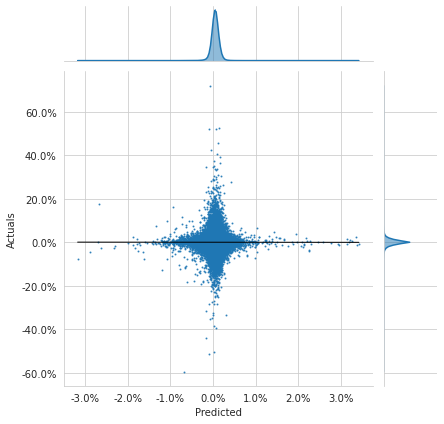

In [31]:
plot_preds_scatter(lr_predictions)


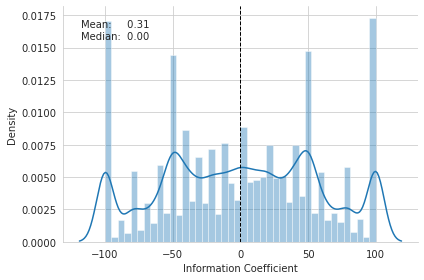

In [32]:
plot_ic_distribution(lr_scores)


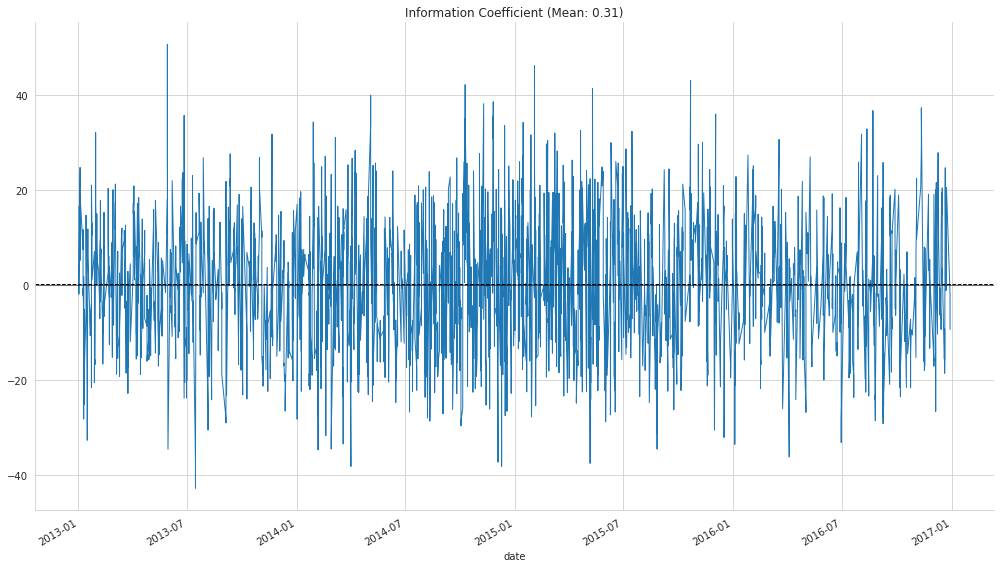

In [37]:
plot_rolling_ic(lr_scores)


## Regularized Linear Regression

### Ridge Regression

In [38]:
ridge_alphas = np.logspace(-4, 4, 9)
ridge_alphas = sorted(list(ridge_alphas) + list(ridge_alphas * 5))

In [39]:
X = X.drop([c for c in X.columns if 'year' in c], axis=1)


In [45]:
ridge_coeffs, ridge_scores, ridge_predictions = {}, [], []

for alpha in ridge_alphas:
    print(alpha, end=' ', flush=True)
    start = time()
    model = Ridge(alpha=alpha,
                  fit_intercept=False,
                  random_state=42)

    pipe = Pipeline([
        ('scaler', MinMaxScaler()),
        ('model', model)])

    coeffs = []
    for i, (train_idx, test_idx) in enumerate(cv.split(X), 1):
        X_train, y_train, = X.iloc[train_idx], targets.iloc[train_idx]
        X_test, y_test = X.iloc[test_idx], targets.iloc[test_idx]
        
        
        pipe.fit(X=X_train, y=y_train)
        y_pred = pipe.predict(X_test)

        preds = y_test.to_frame('actuals').assign(predicted=y_pred)
        preds_by_day = preds.groupby(level='date')
        scores = pd.concat([preds_by_day.apply(lambda x: spearmanr(x.predicted,
                                                                   x.actuals)[0] * 100)
                            .to_frame('ic')],axis=1)

        ridge_scores.append(scores.assign(alpha=alpha))
        ridge_predictions.append(preds.assign(alpha=alpha))

        coeffs.append(pipe.named_steps['model'].coef_)
    ridge_coeffs[alpha] = np.mean(coeffs, axis=0)


0.0001 0.0005 0.001 0.005 0.01 0.05 0.1 0.5 1.0 5.0 10.0 50.0 100.0 500.0 1000.0 5000.0 10000.0 50000.0 

In [46]:
ridge_scores = pd.concat(ridge_scores)
ridge_scores.to_hdf('data.h5', 'ridge/scores')

ridge_coeffs = pd.DataFrame(ridge_coeffs, index=X.columns).T
ridge_coeffs.to_hdf('data.h5', 'ridge/coeffs')

ridge_predictions = pd.concat(ridge_predictions)
ridge_predictions.to_hdf('data.h5', 'ridge/predictions')

In [47]:
ridge_r, ridge_p = spearmanr(ridge_predictions.actuals, ridge_predictions.predicted)
print(f'Information Coefficient (overall): {ridge_r:.3%} (p-value: {ridge_p:.4%})')

Information Coefficient (overall): -0.184% (p-value: 0.0003%)


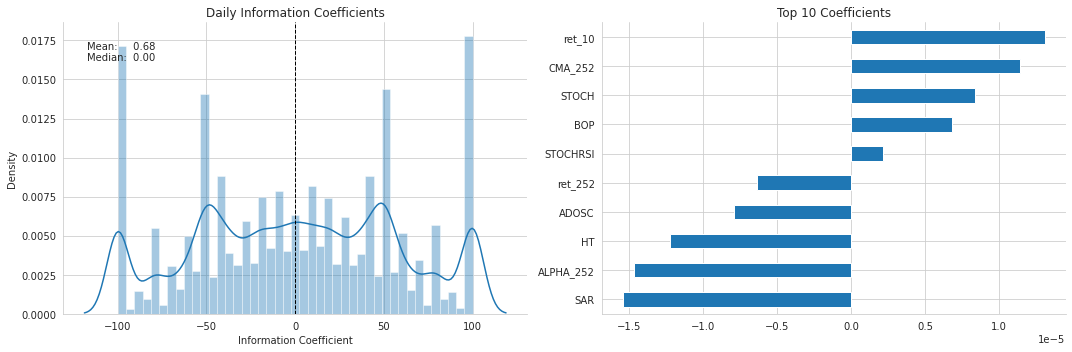

In [48]:
best_alpha = ridge_scores.groupby('alpha').ic.mean().idxmax()
fig, axes = plt.subplots(ncols=2, figsize=(15, 5))
plot_ic_distribution(ridge_scores[ridge_scores.alpha == best_alpha],
                     ax=axes[0])
axes[0].set_title('Daily Information Coefficients')
top_coeffs = ridge_coeffs.loc[best_alpha].abs().sort_values().head(10).index
top_coeffs.tolist()
ridge_coeffs.loc[best_alpha, top_coeffs].sort_values().plot.barh(ax=axes[1],
                                                                 title='Top 10 Coefficients')
sns.despine()
fig.tight_layout()

### Lasso Regression

In [49]:
lasso_alphas = np.logspace(-10, -3, 8)

In [50]:
scalar = MinMaxScaler()

In [51]:
lasso_coeffs, lasso_scores, lasso_predictions = {}, [], []
for alpha in lasso_alphas:
    print(alpha, end=' ', flush=True)
    model = Lasso(alpha=alpha,
                  fit_intercept=False,  # MinMaxScaler centers data
                  random_state=42,
                  tol=1e-3,
                  max_iter=1000,
                  warm_start=True,
                  selection='random')

    pipe = Pipeline([
        ('scaler', MinMaxScaler()),
        ('model', model)])
    coeffs = []
    for i, (train_idx, test_idx) in enumerate(cv.split(X), 1):
        X_train, y_train, = X.iloc[train_idx], targets.iloc[train_idx]
        X_test, y_test = X.iloc[test_idx], targets.iloc[test_idx]
        
        
        pipe.fit(X=X_train, y=y_train)
        y_pred = pipe.predict(X_test)

        preds = y_test.to_frame('actuals').assign(predicted=y_pred)
        preds_by_day = preds.groupby(level='date')
        scores = pd.concat([preds_by_day.apply(lambda x: spearmanr(x.predicted,
                                                                   x.actuals)[0] * 100)
                            .to_frame('ic')],axis=1)
        
        lasso_scores.append(scores.assign(alpha=alpha))
        lasso_predictions.append(preds.assign(alpha=alpha))

        coeffs.append(pipe.named_steps['model'].coef_)

    lasso_coeffs[alpha] = np.mean(coeffs, axis=0)

1e-10 1e-09 1e-08 1e-07 1e-06 1e-05 0.0001 0.001 

In [52]:
lasso_scores = pd.concat(lasso_scores)
lasso_scores.to_hdf('data.h5', 'lasso/scores')

lasso_coeffs = pd.DataFrame(lasso_coeffs, index=X.columns).T
lasso_coeffs.to_hdf('data.h5', 'lasso/coeffs')

lasso_predictions = pd.concat(lasso_predictions)
lasso_predictions.to_hdf('data.h5', 'lasso/predictions')

In [53]:
best_alpha = lasso_scores.groupby('alpha').ic.mean().idxmax()
preds = lasso_predictions[lasso_predictions.alpha==best_alpha]

lasso_r, lasso_p = spearmanr(preds.actuals, preds.predicted)
print(f'Information Coefficient (overall): {lasso_r:.3%} (p-value: {lasso_p:.4%})')

Information Coefficient (overall): 0.035% (p-value: 83.0884%)


In [54]:
lasso_scores.groupby('alpha').ic.agg(['mean', 'median'])

,mean,median
alpha,,
1.000000e-10,0.472703,0.0
1.000000e-09,0.469828,0.0
1.000000e-08,0.480183,0.0
1.000000e-07,0.467993,0.0
1.000000e-06,0.439425,0.0
1.000000e-05,0.370353,0.0
1.000000e-04,0.278957,0.0
1.000000e-03,NaN,NaN


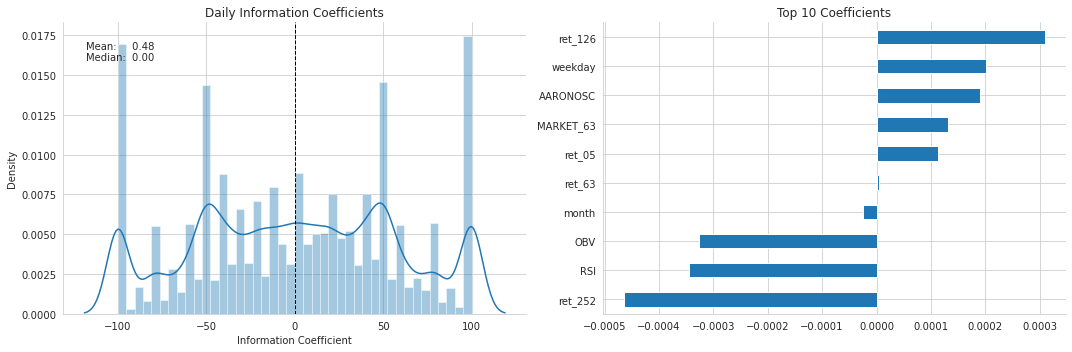

In [55]:
best_alpha = lasso_scores.groupby('alpha').ic.mean().idxmax()

fig, axes = plt.subplots(ncols=2, figsize=(15, 5))
plot_ic_distribution(lasso_scores[lasso_scores.alpha==best_alpha], ax=axes[0])
axes[0].set_title('Daily Information Coefficients')

top_coeffs = lasso_coeffs.loc[best_alpha].abs().sort_values().head(10).index
top_coeffs.tolist()
lasso_coeffs.loc[best_alpha, top_coeffs].sort_values().plot.barh(ax=axes[1], title='Top 10 Coefficients')

sns.despine()
fig.tight_layout();